In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from models import DNMC, NMC, NSurv, MLP, discrete_ci, train_model, evaluate_model
from generate_data import onehot

import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(2021)

In [2]:
tf.__version__

'2.4.0'

In [3]:
df = pd.read_csv('../datasets/stroke_risk_ads_v2.csv')

/Users/mme/miniforge3/envs/tf2.4/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
FRAMINGHAM_PREDICTORS = ['age', 'sex', 'sysbp', 'hrx', 'hxcvd', 'lvh', 'currsmk', 'afib', 'diab']
REGARDS_PREDICTORS = ['age', 'sex', 'race_c', 'afib', 'hrx', 'hxmi', 'currsmk', 'educlev', 'genhlth', 'genhlth2']
ASCVD_PREDICTORS = ['age', 'tc', 'hdl', 'sysbp', 'hrx', 'currsmk', 'diab']

ALL_PREDICTORS = list(set(FRAMINGHAM_PREDICTORS) | set(REGARDS_PREDICTORS) | set(ASCVD_PREDICTORS))

# probably easiest to treat genhlth(2) as numeric
# check with Daniel

OUTCOMES = ['stroke', 't2stroke']

PREDICTORS = list(set(FRAMINGHAM_PREDICTORS) | set(ASCVD_PREDICTORS))

print(PREDICTORS)

['lvh', 'sysbp', 'currsmk', 'hdl', 'sex', 'age', 'afib', 'tc', 'diab', 'hrx', 'hxcvd']


In [5]:
frame = df[df['study'] != 'REGARDS'].sample(frac=1., random_state=99)

val_idx = int(len(frame) * .7)
test_idx = int(len(frame) * .85)

train_frame = frame[:val_idx][PREDICTORS]

train_median = train_frame.median()
train_frame = train_frame.fillna(train_median)

train_mean = train_frame.mean()
train_std = train_frame.std()

x_train = ((train_frame - train_mean) / train_std).values

x_val = ((frame[val_idx:test_idx][PREDICTORS].fillna(train_median) - train_mean) / train_std).values
x_test = ((frame[test_idx:][PREDICTORS].fillna(train_median) - train_mean) / train_std).values

regards_frame = df[df['study'] == 'REGARDS'].sample(frac=1., random_state=99)
                  
x_regards = ((regards_frame[PREDICTORS].fillna(train_median) - train_mean) / train_std).values

print('Frame sizes are', x_train.shape, x_val.shape, x_test.shape, x_regards.shape)

Frame sizes are (26527, 11) (5684, 11) (5685, 11) (27032, 11)


In [6]:
### SET GLOBAL PARAMETERS

N_FEATURES = train_frame.shape[1]
N_BINS = 10
LEARNING_RATE = 6e-4

rs = np.random.RandomState(7)

In [7]:
s = frame['stroke'].values

s_train = s[:val_idx]
s_val = s[val_idx:test_idx]
s_test = s[test_idx:]
s_regards = regards_frame['stroke'].values

y_continuous = frame['t2stroke'].values
y_regards_continuous = regards_frame['t2stroke'].values
y_all = np.concatenate([y_continuous, y_regards_continuous])

y_disc = np.zeros_like(y_continuous)
y_regards_disc = np.zeros_like(y_regards_continuous)

for i in range(1, N_BINS):

    prc = np.percentile(y_all, 100 * i / N_BINS)

    y_disc = y_disc + (y_continuous > prc).astype(int)
    y_regards_disc = y_regards_disc + (y_regards_continuous > prc).astype(int)

y = onehot(y_disc)

y_train = y[:val_idx]
y_val = y[val_idx:test_idx]
y_test = y[test_idx:]

y_regards = onehot(y_regards_disc)

print(
    s_train.shape, y_train.shape,
    s_val.shape, y_val.shape,
    s_test.shape, y_test.shape,
    s_regards.shape, y_regards.shape)

(26527,) (26527, 10) (5684,) (5684, 10) (5685,) (5685, 10) (27032,) (27032, 10)


In [10]:
model = DNMC(n_bins=N_BINS, lr=.03, ld=10.)
        
train_model(
    model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    300, batch_size=500,
    learning_rate=1e-3)

Epoch  7 | Train Loss: 2.9476 | Train NLL: 2.1548 | Val Loss: 2.9680 | Val NLL: 2.17278



In [26]:
def get_batches(arr, batch_size=1):
    l = len(arr)
    for ndx in range(0, l, batch_size):
        yield arr[ndx:min(ndx + batch_size, l)]

def get_predictions(mdl, x_all, batch_size=50):
    
    e_pred_all, t_pred_all, c_pred_all = [], [], []

    for xt in get_batches(x_all, batch_size=batch_size):

        e_pred, t_pred, c_pred = model(xt)
        e_pred_all.append(e_pred)
        t_pred_all.append(t_pred)
        c_pred_all.append(c_pred)
        
    return (np.concatenate(arrs, axis=0) for arrs in (e_pred_all, t_pred_all, c_pred_all))

In [73]:
e_test_pred, t_test_pred, c_test_pred = get_predictions(model, x_test)
e_test_regards, t_test_regards, c_test_regards = get_predictions(model, x_regards)

In [74]:
from models import discrete_ci
from sklearn.metrics import roc_auc_score

In [89]:
test_ci = discrete_ci(
    s_test, y_test,
    e_test_pred[:, np.newaxis] * t_test_pred
)

regards_ci = discrete_ci(
    s_regards, y_regards,
    e_test_regards[:, np.newaxis] * t_test_regards
)

In [90]:
test_ci, regards_ci

(0.7184070244944746, 0.6650356378426125)

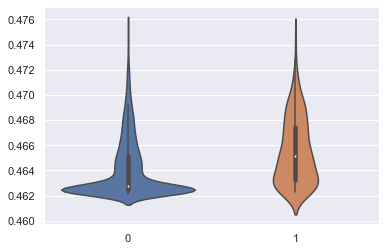

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.violinplot(x=s_test, y=e_test_pred, labels=['hi', 'hello'])
plt.show()

In [93]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(e_test_pred[s_test == 1], e_test_pred[s_test == 0]))
print('cohens d is', (e_test_pred[s_test == 1].mean() - e_test_pred[s_test == 0].mean()) / e_test_pred.std())

MannwhitneyuResult(statistic=907093.0, pvalue=4.001159753692566e-26)
cohens d is 0.61464655


In [78]:
PREDICTOR_DICT = {
    'sex': 'Sex',
    'age': 'Age',
    'sysbp': 'Systolic Blood Pressure',
    'hrx': 'Treated for High Blood Pressure',
    'hxcvd': 'History of Cardiovascular Disease',
    'lvh': 'Left Ventricular Hypertrophy',
    'currsmk': 'Current Smoker',
    'afib': 'Atrial Fibrillation',
    'diab': 'Diabetes',
    'tc': 'Total Cholesterol',
    'hdl': 'HDL Cholesterol'
}

In [79]:
importances = pd.DataFrame({
    'predictor': [PREDICTOR_DICT[p] for p in PREDICTORS],
    'omega_max': np.abs(model.omega_layers[0].get_weights()[0]).max(axis=1),
    'psi_max': np.abs(model.psi_layers[0].get_weights()[0]).max(axis=1),
    'phi_max': np.abs(model.phi_layers[0].get_weights()[0]).max(axis=1),
    'omega_avg': np.abs(model.omega_layers[0].get_weights()[0]).mean(axis=1),
    'psi_avg': np.abs(model.psi_layers[0].get_weights()[0]).mean(axis=1),
    'phi_avg': np.abs(model.phi_layers[0].get_weights()[0]).mean(axis=1)
})

In [87]:
# TIMING
timing = importances.set_index('predictor')['omega_avg'].sort_values(ascending=False)
timing = (timing / timing.max()).round(2).to_clipboard()

In [88]:
# SUSCEPTIBILITY
suscept = importances.set_index('predictor')['phi_avg'].sort_values(ascending=False)
suscept = (suscept / suscept.max()).round(2).to_clipboard()

In [85]:
# SHARED
importances.sort_values(by='psi_avg', ascending=False)

,predictor,omega_max,psi_max,phi_max,omega_avg,psi_avg,phi_avg
5,Age,0.161333,0.066443,0.000140,0.042875,0.008880,0.000007
7,Total Cholesterol,0.111981,0.020937,0.000143,0.034707,0.002630,0.000009
2,Current Smoker,0.074408,0.012352,0.000264,0.023891,0.001988,0.000010
1,Systolic Blood Pressure,0.100994,0.012943,0.000268,0.033943,0.001889,0.000013
10,History of Cardiovascular Disease,0.098967,0.007927,0.000201,0.015997,0.001864,0.000012
4,Sex,0.094191,0.010890,0.000286,0.023818,0.001778,0.000010
8,Diabetes,0.090581,0.008946,0.000212,0.015452,0.001424,0.000011
9,Treated for High Blood Pressure,0.079775,0.008171,0.000279,0.015196,0.001085,0.000011
6,Atrial Fibrillation,0.031679,0.006921,0.000199,0.006337,0.001023,0.000011
3,HDL Cholesterol,0.112819,0.005123,0.000196,0.029817,0.000892,0.000008


In [91]:
nmc_model = NMC(n_bins=N_BINS, lr=.03, ld=10.)
        
train_model(
    nmc_model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    300, batch_size=500,
    learning_rate=1e-3)

Epoch 50 | Train Loss: 2.1472 | Train NLL: 2.1044 | Val Loss: 2.1699 | Val NLL: 2.12759



In [99]:
e_test_pred_nmc, t_test_pred_nmc, c_test_pred_nmc = get_predictions(nmc_model, x_test)
e_test_regards_nmc, t_test_regards_nmc, c_test_regards_nmc = get_predictions(nmc_model, x_regards)

test_ci_nmc = discrete_ci(
    s_test, y_test,
    e_test_pred_nmc[:, np.newaxis] * t_test_pred_nmc
)

regards_ci_nmc = discrete_ci(
    s_regards, y_regards,
    e_test_regards_nmc[:, np.newaxis] * t_test_regards_nmc
)

print(test_ci_nmc, regards_ci_nmc)

0.7184070244944746 0.6650356378426125


In [98]:
nsurv_model = NSurv(n_bins=N_BINS, lr=.03, ld=10.)
        
train_model(
    nsurv_model, (x_train, y_train, s_train), (x_val, y_val, s_val),
    300, batch_size=500,
    learning_rate=1e-3)

Epoch 66 | Train Loss: 2.1412 | Train NLL: 2.0994 | Val Loss: 2.1643 | Val NLL: 2.12307



In [101]:
e_test_pred_nsurv, t_test_pred_nsurv, c_test_pred_nsurv = get_predictions(nsurv_model, x_test)
e_test_regards_nsurv, t_test_regards_nsurv, c_test_regards_nsurv = get_predictions(nsurv_model, x_regards)

test_ci_nsurv = discrete_ci(
    s_test, y_test,
    e_test_pred_nsurv[:, np.newaxis] * t_test_pred_nsurv
)

regards_ci_nsurv = discrete_ci(
    s_regards, y_regards,
    e_test_regards_nsurv[:, np.newaxis] * t_test_regards_nsurv
)

print(test_ci_nsurv, regards_ci_nsurv)

0.7184070244944746 0.6650356378426125
